<a href="https://colab.research.google.com/github/vatj/boat-count/blob/main/boat_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [46]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [56]:
class BoatCounter:
  
  def __init__(self):
    colors = list(ImageColor.colormap.values())

    self.video_path = "/content/Test-Task Sequence from Wörthersee.mp4"
    self.module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
    self.confidence_threshold = 0.75
    self.mean_iou_threshold = 0.6
    self.max_area = 300 * 500
    self.boat_count = 0
    self.color = colors[1]
    self.thickness = 10
    self.boxed_frames = []
    self.load_video()
    self.load_model()

  def load_model(self):
    # self.detector = hub.load(self.module_handle).signatures['default']
    self.detector = detector

  def load_video(self):
    self.cap = cv2.VideoCapture(self.video_path)
    self.width  = self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)  
    self.height = self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    self.video_writer = cv2.VideoWriter(
        '/content/test.mp4', 
        fourcc, 
        float(self.cap.get(cv2.CAP_PROP_FPS)), 
        (int(self.width), int(self.height))
        )

  def main(self):
    count = 0

    while self.cap.isOpened():
      print(f"frame {count}")
      _ , frame = self.cap.read()
      self.current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      self.run_single_inference()
      self.postprocess_inference()
      self.draw_all_boxes()
      self.save_box_frames_to_video()

      if count > 10:
        break
    
      count += 1
    
    self.video_writer.release()
    #   self.run_all_mean_IOU_trackers()

  def run_single_inference(self):
    converted_frame = self.preprocess_frame_for_inference()
    self.current_output = self.detector(converted_frame)

  def preprocess_frame_for_inference(self):
    return tf.image.convert_image_dtype(tf.convert_to_tensor(self.current_frame), dtype=tf.float32)[tf.newaxis, ...]

  def postprocess_inference(self):
    numpy_outputs = {key: value.numpy() for key, value in self.current_output.items()}
    self.postprocess_outputs = []

    for index, key in enumerate(numpy_outputs["detection_class_entities"]):
      # Filter for boats over the confidence threshold
      if ((key == b"Boat") and (numpy_outputs["detection_scores"][index] > self.confidence_threshold)):
        # Check for size to exclude the driving boat
        if self.check_area(numpy_outputs["detection_boxes"][index]):
          self.postprocess_outputs.append(numpy_outputs["detection_boxes"][index])

  def check_area(self, box_coord):
     ymin, xmin, ymax, xmax = tuple(box_coord)
     area = (xmax - xmin) * self.width * (ymax - ymin) * self.height

     if area < self.max_area:
       return True
     else:
       return False


  def draw_bounding_box_on_image(self, image, ymin, xmin, ymax, xmax):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    (left, right, top, bottom) = (xmin * self.width, xmax * self.width,
                                  ymin * self.height, ymax * self.height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
              (left, top)],
              width=self.thickness,
              fill=self.color)

  def draw_all_boxes(self):
    """Overlay labeled boxes on an image with formatted scores and label names."""

    for box_coord in self.postprocess_outputs:
      ymin, xmin, ymax, xmax = tuple(box_coord)
      image_pil = Image.fromarray(np.uint8(self.current_frame)).convert("RGB")
      self.draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax)
      np.copyto(self.current_frame, np.array(image_pil))


  def run_single_mean_IOU_tracker(self, current_object_coord, previous_object_coord_list):
    raise NotImplementedError()

  def run_all_mean_IOU_trackers(self, current_object_coord_list, previous_object_coord_list):
    raise NotImplementedError()

  def save_box_frames_to_video(self):
    self.video_writer.write(cv2.cvtColor(self.current_frame, cv2.COLOR_RGB2BGR))

In [57]:
my_boat_counter = BoatCounter()

In [58]:
my_boat_counter.main()

frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11


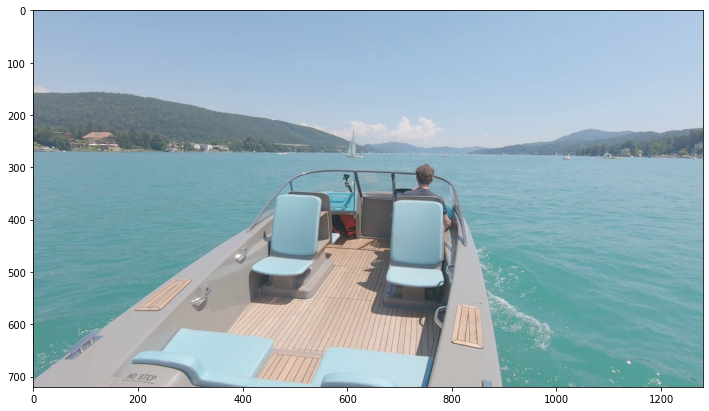

In [59]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

ax.imshow(my_boat_counter.current_frame)